In [1]:
import networkx as nx
import cv2
import numpy as np
import scipy as sp
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, fsolve
from scipy.spatial.transform import Rotation
from scipy.spatial.distance import cdist

from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian

import craterdetection.common.constants as const
from craterdetection.common.camera import Camera
from craterdetection.common.coordinates import nadir_attitude, ENU_system
from craterdetection.matching.database import extract_robbins_dataset, load_craters, CraterDatabase
from craterdetection.matching.projective_invariants import crater_representation, CoplanarInvariants, scale_det
from craterdetection.matching.utils import cyclic_permutations, enhanced_pattern_shifting, is_clockwise, all_clockwise, \
    np_swap_columns, is_colinear, cw_or_ccw, get_cliques_by_length
from craterdetection.common.conics import *



In [2]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[5, 10], ellipse_limit=1.3)
)
r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

In [3]:
resolution = const.CAMERA_RESOLUTION

# Camera parameters can be derived from RNG
cam_lat, cam_long = map(np.radians, (45., 45.))
cam_alt = 500

cam = Camera.from_coordinates(cam_lat, cam_long, cam_alt, resolution=resolution)

# cam.T = (Rotation.from_matrix(cam.T) * Rotation.from_euler('x', 0, degrees=True)).as_matrix()

dist = cam_alt / np.cos(np.radians(cam.fov/2)*np.sqrt(2)*1.0)
vicinity = (np.sqrt(np.sum(np.square(r_craters_cat - cam.r), axis=1)) < dist).ravel()
r_craters = r_craters_cat[vicinity]
C_craters = C_craters_cat[vicinity]
A_craters = cam.project_crater_conics(C_craters, r_craters)

crater_centers = cam.project_crater_centers(r_craters)

C:\dev\workspace\crater-detection\craterdetection\common\conics.py:150: UserWarning: No contour levels were found within the data range.
  ax.contour(x_plot, y_plot, c.reshape(x_plot.shape), [0], colors=rim_color)


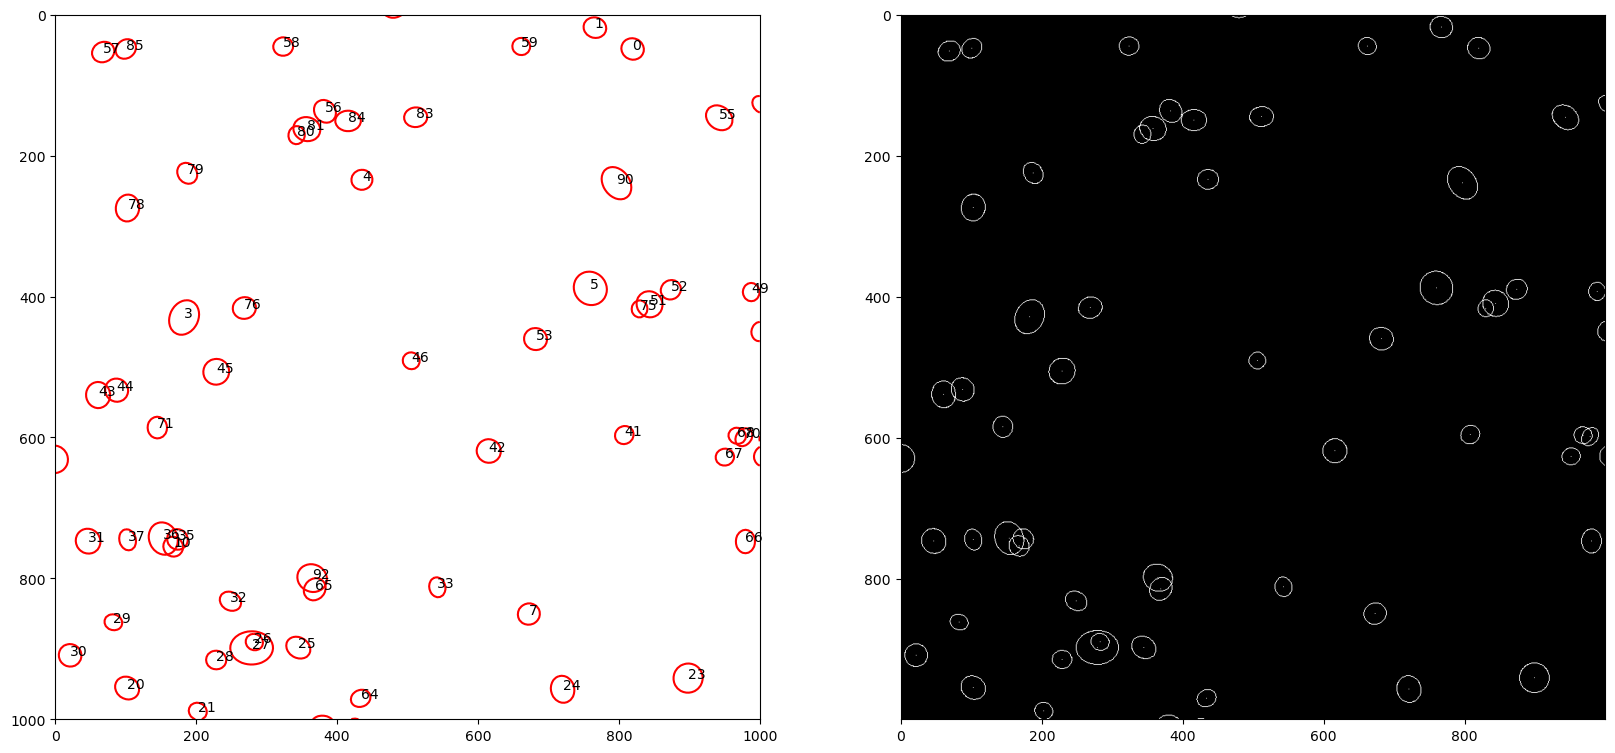

In [4]:
plt.style.use('default')

fig, axes = plt.subplots(1, 2, figsize=(20, 40), subplot_kw={'aspect': 'equal'})

plot_conics(A_craters, resolution=cam.resolution, plot_centers=True, ax=axes[0])
detection_order = np.argsort(cdist(crater_centers, np.array(cam.resolution)[None, :]/2).squeeze())

# plot_conics(A_craters[detection_order], resolution=cam.resolution, plot_centers=True, ax=axes[1])

img_ellipses = np.zeros(resolution)
for a_i in A_craters:
    center_coordinates = tuple(conic_center(a_i).astype(int))
    axes_length = map(round, ellipse_axes(a_i))
    angle = round(np.degrees(ellipse_angle(a_i)))
    img_ellipses = cv2.ellipse(img_ellipses, center_coordinates, tuple(axes_length),
                               angle, 0, 360, (255, 255, 255), 1)
    img_ellipses = cv2.circle(img_ellipses, center_coordinates, 0, (255, 255, 255), 1)

axes[1].imshow(img_ellipses, cmap='Greys_r')

In [5]:
db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv", diamlims=[5, 10], latlims=[35, 55], longlims=[35, 55], radius=300, ellipse_limit=1.3)
# db = CraterDatabase(lat_cat[vicinity], long_cat[vicinity], major_cat[vicinity], minor_cat[vicinity], psi_cat[vicinity], radius=500)

In [6]:
np.set_printoptions(precision=3)
max_diff = 0.02
correct_matches = {detection_key : [] for detection_key, _ in enumerate(A_craters[detection_order])}
max_iter = 1e1

for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters[detection_order])):
    for order in cyclic_permutations(np.arange(3)):
        order_full = np.append(np.concatenate((order, order+3)), -1)

        diff = np.mean(np.abs(((db.features - features[order_full])/features[order_full])), axis=1)

        if np.min(diff) < max_diff:
            min_idx = np.argwhere(diff <= max_diff)

            subset_match = np.logical_and.reduce(lat_cat[vicinity][detection_order][crater_triad[order]] \
                                                                             == db.get_position(min_idx)[0].T, axis=2)
            if np.logical_or.reduce(subset_match):
                print(f"MATCH [{i}]")
                match = min_idx[np.where(subset_match)].item()
                print(crater_triad)
                print(order_full)

                rank = np.where(np.sort(diff) == diff[match])[0].item()
                print(f"\tMean difference: {diff[match]:.2%}, position: "
                      f"{rank}")

                print("\tDetection feature: \t", features[order_full])
                print("\tDB match feature: \t", db.features[match])

                print("\tCrater triad coords: \t",
                      lat_cat[vicinity][detection_order][crater_triad[order]],
                      long_cat[vicinity][detection_order][crater_triad[order]])
                print("\tDB match coords: \t", *db.get_position(match))
                for detection_idx, db_idx in zip(crater_triad[order], db.crater_triads[match]):
                    correct_matches[detection_idx] += [db_idx]
                print()
                break

    if i >= max_iter:
        break


MATCH [0]
[0 1 2]
[ 0  1  2  3  4  5 -1]
	Mean difference: 0.23%, position: 0
	Detection feature: 	 [-148.87  -108.535 -148.349 -116.129 -110.673 -172.411 -804.94 ]
	DB match feature: 	 [-148.976 -108.727 -148.868 -116.491 -110.916 -172.541 -808.3  ]
	Crater triad coords: 	 [0.788 0.757 0.794] [0.787 0.823 0.847]
	DB match coords: 	 [0.788 0.757 0.794] [0.787 0.823 0.847]

MATCH [1]
[3 4 5]
[ 1  2  0  4  5  3 -1]
	Mean difference: 0.48%, position: 0
	Detection feature: 	 [ -399.014  -257.445   -31.227  -455.775  -247.129   -29.196 -1393.321]
	DB match feature: 	 [ -402.29   -258.296   -31.275  -459.031  -248.447   -29.183 -1403.467]
	Crater triad coords: 	 [0.782 0.849 0.804] [0.693 0.762 0.705]
	DB match coords: 	 [0.782 0.849 0.804] [0.693 0.762 0.705]

MATCH [2]
[6 7 8]
[ 0  1  2  3  4  5 -1]
	Mean difference: 1.22%, position: 0
	Detection feature: 	 [ -596.429  -647.055  -168.394  -955.14   -794.249  -123.241 -3399.145]
	DB match feature: 	 [ -610.734  -649.679  -169.465  -968.312 

In [7]:
np.set_printoptions(precision=3)
max_diff = 0.02
correct_matches = {detection_key : [] for detection_key, _ in enumerate(A_craters[detection_order])}
max_iter = 1e2

for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters[detection_order])):
    for order in cyclic_permutations(np.arange(3)):
        order_full = np.append(np.concatenate((order, order+3)), -1)

        diff = np.mean(np.abs(((db.features - features[order_full])/features[order_full])), axis=1)

        if np.min(diff) < max_diff:
            min_idx = np.argmin(diff)

            for detection_idx, db_idx in zip(crater_triad[order], db.crater_triads[min_idx]):
                correct_matches[detection_idx] += [db_idx]
            break

    if i >= max_iter:
        break

In [8]:
for k, v in correct_matches.items():
    if len(v) >= 2:
        print(k, v)

0 [71, 71]
1 [67, 67, 67]
2 [75, 75, 75]
3 [99, 99, 99, 99, 99]
4 [70, 70, 70, 70]
5 [4, 4, 4]
6 [5, 5, 5, 5]
7 [59, 59]
10 [115, 115]
12 [92, 92]
14 [73, 73]
15 [105, 105, 105, 105]
16 [102, 102, 102, 102]
17 [97, 97, 97]
18 [103, 103, 103, 103]
19 [77, 77]
20 [74, 74]
24 [69, 69, 69]
25 [101, 101, 101]
26 [58, 58]
27 [11, 11, 11]
28 [62, 62, 62]
29 [51, 51]
30 [68, 68, 68, 68]
31 [52, 52]
32 [53, 53]
81 [40, 40]
82 [28, 28]


In [9]:
def vectorize(arr):
    return arr.reshape(-1, np.multiply(*arr.shape[-2:]), 1)

def derive_position(A_craters_, r_craters_, C_craters_, T_CM, K, qr=True):
    A_craters_, C_craters_ = map(scale_det, (A_craters_, C_craters_))
    k = np.array([0., 0., 1.])[:, None]
    S = np.concatenate((np.identity(2), np.zeros((1, 2))), axis=0)

    B_craters = T_CM @ K.T @ A_craters_ @ K @ LA.inv(T_CM)
    T_EM = np.concatenate(ENU_system(r_craters_), axis=-1)
    T_ME = LA.inv(T_EM)

    scale_i = (vectorize(S.T @ C_craters_ @ S).transpose(0, 2, 1) @ vectorize(S.T @ T_ME @ B_craters @ T_EM @ S)) \
            / (vectorize(S.T @ C_craters_ @ S).transpose(0, 2, 1) @ vectorize(S.T @ C_craters_ @ S))

    A = (S.T @ T_ME @ B_craters).reshape(-1, 3)
    b = (S.T @ T_ME @ B_craters @ r_craters_ - scale_i * S.T @ C_craters_ @ k).reshape(-1, 1)

    if qr:
        Q, R = LA.qr(A)
        Qb = np.dot(Q.T, b)
        return LA.solve(R, Qb)
    else:
        return LA.lstsq(A, b, rcond=None)[0]

est_pos = derive_position(A_craters[4:10], r_craters[4:10], C_craters[4:10], cam.T, cam.K())
print(f"Position error: {LA.norm(cam.r.ravel() - est_pos.ravel()):.2f} km")

Position error: 297.32 km


In [10]:
A_craters = scale_det(A_craters)
k = np.array([0., 0., 1.])[:, None]
S = np.concatenate((np.identity(2), np.zeros((1, 2))), axis=0)

B_craters = cam.T @ cam.K().T @ A_craters @ cam.K() @ LA.inv(cam.T)
T_EM = np.concatenate(ENU_system(r_craters), axis=-1)
T_ME = LA.inv(T_EM)

scale_i = vectorize(S.T @ C_craters @ S).transpose(0, 2, 1) @ vectorize(S.T @ T_ME @ B_craters @ T_EM @ S) \
        / (vectorize(S.T @ C_craters @ S).transpose(0, 2, 1) @ vectorize(S.T @ C_craters @ S))

linsys_A = (S.T @ T_ME @ B_craters).reshape(-1, 3)
linsys_B = (S.T @ T_ME @ B_craters @ r_craters - scale_i * S.T @ C_craters @ k).reshape(-1, 1)

LA.lstsq(linsys_A, linsys_B)[0]

C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


array([[1011.639],
       [ 862.038],
       [1474.303]])

In [11]:
cam.r

array([[1118.55 ],
       [1118.55 ],
       [1581.869]])